# **Ant Colony Optimization (TSP)**

## Bio-Inspired Computing
### Mikel Ignacio Barajas Martínez

### 09/03/24

𝝮

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import time

## Model

Each problem (model) is represented as a complete graph with n nodes.

Each node has a position in 2D space, and the edge weights are the euclidean distances between nodes

In [3]:
class Model():

    def __init__(self, coords, adj):
        self.n = len(coords)
        self.coords = coords
        self.adj = adj

    def __repr__(self):
        header = f'Model (n={self.n})'
        adj_str = np.array2string(self.adj, precision=2, separator=', ', suppress_small=True)
        return f'{header}\nAdjacency Matrix:\n{adj_str}'

    def load_coords(self, coords_path):
        coords = []
        with open(coords_path, 'r') as f:
            for line in f:

                if line[0] == '#':
                    continue

                coord = list(map(float, line.strip().split()))
                coords.append(coord)
                
        return coords
    
    def build_adj(self):
        adj = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(i+1, self.n):
                adj[i][j] = np.sqrt((self.coords[i][0] - self.coords[j][0])**2 + (self.coords[i][1] - self.coords[j][1])**2)
                adj[j][i] = adj[i][j]
        return adj

    def __init__(self, coords=None, coords_path='data/SP11/sp11_xy.txt'):
        self.coords = coords if coords else self.load_coords(coords_path)
        self.n = len(self.coords)
        self.adj = self.build_adj()

    def plot(self, edges=True):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if edges:
            for i in range(self.n):
                for j in range(i+1, self.n):
                   ax.plot([self.coords[i][0], self.coords[j][0]], [self.coords[i][1], self.coords[j][1]], c='black', alpha=0.2, linewidth=0.5)

        ax.scatter(*zip(*self.coords), c='r', zorder=10)

        plt.show()

Model (n=4)
Adjacency Matrix:
[[0.  , 1.  , 1.41, 1.  ],
 [1.  , 0.  , 1.  , 1.41],
 [1.41, 1.  , 0.  , 1.  ],
 [1.  , 1.41, 1.  , 0.  ]]


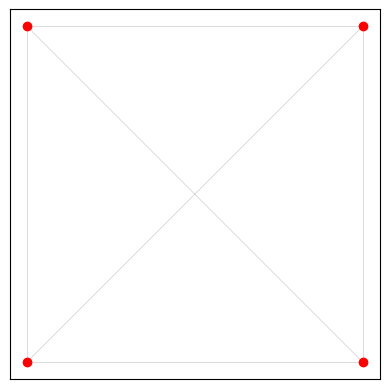

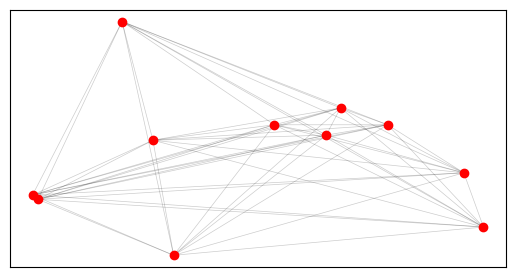

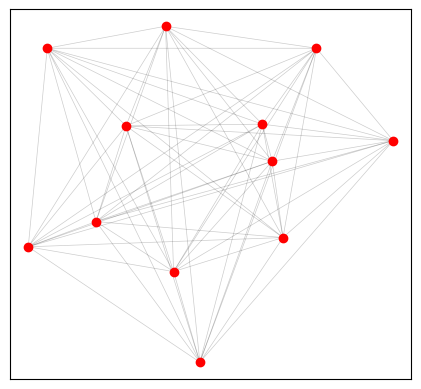

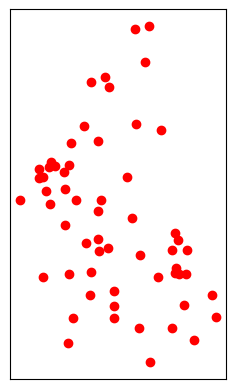

In [4]:
coords = [[0, 0], [1, 0], [1, 1], [0, 1]]
test_map = Model(coords=coords)
print(test_map)
test_map.plot()

sp11 = Model(coords_path='data/SP11/sp11_xy.txt')
# print(sp11)
sp11.plot()

uk12 = Model(coords_path='data/UK12/uk12_xy.txt')
# print(uk12)
uk12.plot()

wg59 = Model(coords_path='data/WG59/wg59_xy.txt')
# print(wg59)
wg59.plot(edges=False)

## ACO

In [13]:
class Ant:

    def __init__(self):
        self.tour = []
        self.cost = 0

class ACO:

    def __init__(self, model, n, iterations, Q=1, alpha=1, beta=1, rho=0.05):
        
        # ACO parameters
        self.model = model # graph model
        self.n = n # number of ants
        self.iterations = iterations 
        self.Q = Q # pheromone
        self.alpha = alpha # pheromone exponential weight
        self.beta = beta # heuristic exponential weight
        self.rho = rho # pheromone evaporation rate
        self.eta = 1 / model.adj # heuristic information

        # pheromone initialization
        self.tau0 = 10 * Q / (model.n * model.adj.mean()) # initial pheromone level
        self.tau = np.ones((model.n, model.n)) * self.tau0 # pheromone matrix

        # ant population
        self.ants = [Ant() for _ in range(n)] 
        self.global_best_tour = None
        self.global_best_cost = float('inf')

        # history
        self.best_history = []
        self.tour_history = []

    def build_tour(self):
        tour = []
        start = np.random.randint(self.model.n)
        tour.append(start)

        for _ in range(self.model.n-1):
            i = tour[-1]
            p = self.tau[i] ** self.alpha * self.eta[i] ** self.beta
            p[tour] = 0
            p /= p.sum()
            j = np.random.choice(self.model.n, p=p)
            tour.append(j)

        tour.append(start)
        return tour
    
    def evaluate_tour(self, tour):
        cost = 0
        for i in range(self.model.n):
            cost += self.model.adj[tour[i]][tour[i+1]]
        return cost
    
    def update_pheromone(self):
        for ant in self.ants:
            for i in range(self.model.n):
                self.tau[ant.tour[i]][ant.tour[i+1]] += self.Q / ant.cost
                self.tau[ant.tour[i+1]][ant.tour[i]] += self.Q / ant.cost

    def update(self, i):

        for ant in self.ants:
            ant.tour = self.build_tour()
            ant.cost = self.evaluate_tour(ant.tour)
            if ant.cost < self.global_best_cost:
                self.global_best_cost = ant.cost
                self.global_best_tour = ant.tour   

        self.update_pheromone()

        self.tau *= (1 - self.rho)
        self.best_history.append(self.global_best_cost)
        self.tour_history.append(self.global_best_tour)

    def run(self, verbose=True):
        start_time = time.time()
        for i in range(self.iterations):
            self.update(i)
            if verbose:
                print(f'Iteration {i}: Best Cost = {self.global_best_cost}')
        print(f'Best Tour: {self.global_best_tour}')
        print(f'Best Cost: {self.global_best_cost}')
        print(f'Time taken: {time.time() - start_time:.6f} seconds')

    def plot_convergence(self):
        plt.plot(self.best_history)
        plt.xlabel('Iteration')
        plt.ylabel('Best Cost')
        plt.show()

    def plot_solution(self, edges=True):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        if edges:
            for i in range(self.model.n):
                for j in range(i+1, self.model.n):
                    ax.plot([self.model.coords[i][0], self.model.coords[j][0]], [self.model.coords[i][1], self.model.coords[j][1]], c='black', alpha=0.2, linewidth=0.5)

        ax.scatter(*zip(*self.model.coords), c='r', zorder=10)

        x = [self.model.coords[self.global_best_tour[i]][0] for i in range(self.model.n+1)]
        y = [self.model.coords[self.global_best_tour[i]][1] for i in range(self.model.n+1)]

        ax.plot(x, y, c='blue', alpha=0.5)

        plt.show()

    def plot_animation(self, edges=True, filename='aco', format='mp4', fps=5, save=False):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        if edges:
            for i in range(self.model.n):
                for j in range(i+1, self.model.n):
                    ax.plot([self.model.coords[i][0], self.model.coords[j][0]], [self.model.coords[i][1], self.model.coords[j][1]], c='black', alpha=0.2, linewidth=0.5)

        ax.scatter(*zip(*self.model.coords), c='r', zorder=10)

        line, = ax.plot([], [], c='blue', alpha=0.5)

        def animate(frame):
            tour = self.tour_history[frame]
            x = [self.model.coords[tour[i]][0] for i in range(self.model.n+1)]
            y = [self.model.coords[tour[i]][1] for i in range(self.model.n+1)]
            line.set_data(x, y)
            return line,

        anim = FuncAnimation(fig, animate, frames=range(self.iterations), blit=True)

        if save:
            if format == 'gif':
                anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
            elif format == 'mp4':
                anim.save(f'{filename}.mp4', writer='ffmpeg', fps=fps)

        plt.show()

    def plot_solution_animation(self, edges=True, filename='aco', format='mp4', fps=5, save=False):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        if edges:
            for i in range(self.model.n):
                for j in range(i+1, self.model.n):
                    ax.plot([self.model.coords[i][0], self.model.coords[j][0]], [self.model.coords[i][1], self.model.coords[j][1]], c='black', alpha=0.2, linewidth=0.5)

        ax.scatter(*zip(*self.model.coords), c='r', zorder=10)

        line, = ax.plot([], [], c='blue', alpha=0.5)

        def animate(frame):
            x = [self.model.coords[self.global_best_tour[i]][0] for i in range(frame)]
            y = [self.model.coords[self.global_best_tour[i]][1] for i in range(frame)]
            line.set_data(x, y)
            return line,

        anim = FuncAnimation(fig, animate, frames=range(self.model.n + 2), blit=True)

        if save:
            if format == 'gif':
                anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
            elif format == 'mp4':
                anim.save(f'{filename}.mp4', writer='ffmpeg', fps=fps)

        plt.show()

 

Iteration 0: Best Cost = 4.0
Iteration 1: Best Cost = 4.0
Iteration 2: Best Cost = 4.0
Iteration 3: Best Cost = 4.0
Iteration 4: Best Cost = 4.0
Iteration 5: Best Cost = 4.0
Iteration 6: Best Cost = 4.0
Iteration 7: Best Cost = 4.0
Iteration 8: Best Cost = 4.0
Iteration 9: Best Cost = 4.0
Iteration 10: Best Cost = 4.0
Iteration 11: Best Cost = 4.0
Iteration 12: Best Cost = 4.0
Iteration 13: Best Cost = 4.0
Iteration 14: Best Cost = 4.0
Iteration 15: Best Cost = 4.0
Iteration 16: Best Cost = 4.0
Iteration 17: Best Cost = 4.0
Iteration 18: Best Cost = 4.0
Iteration 19: Best Cost = 4.0
Iteration 20: Best Cost = 4.0
Iteration 21: Best Cost = 4.0
Iteration 22: Best Cost = 4.0
Iteration 23: Best Cost = 4.0
Iteration 24: Best Cost = 4.0
Iteration 25: Best Cost = 4.0
Iteration 26: Best Cost = 4.0
Iteration 27: Best Cost = 4.0
Iteration 28: Best Cost = 4.0
Iteration 29: Best Cost = 4.0
Iteration 30: Best Cost = 4.0
Iteration 31: Best Cost = 4.0
Iteration 32: Best Cost = 4.0
Iteration 33: Best C

/tmp/ipykernel_3881/2834329955.py:19: RuntimeWarning: divide by zero encountered in divide
  self.eta = 1 / model.adj # heuristic information


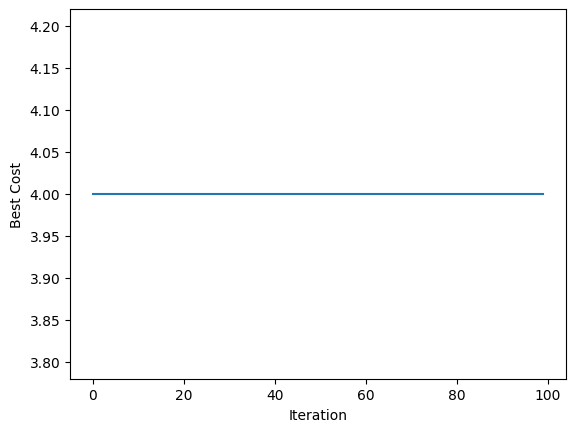

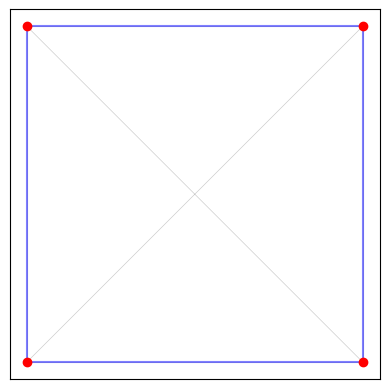

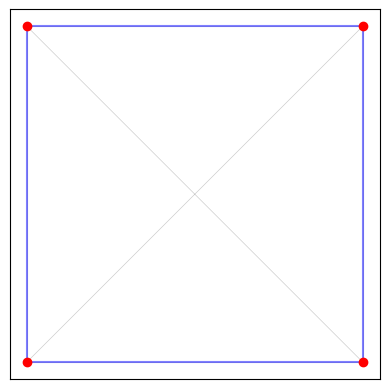

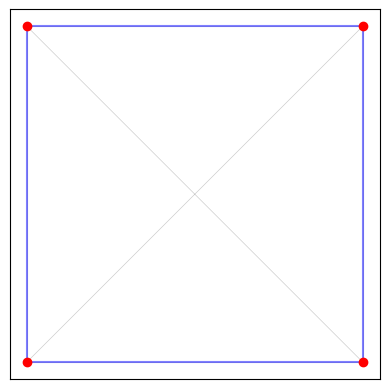

In [14]:
aco1 = ACO(test_map, n=10, iterations=100)
aco1.run()
aco1.plot_convergence()
aco1.plot_solution()
aco1.plot_animation(save=True)
aco1.plot_solution_animation(filename='tour', save=True)

/tmp/ipykernel_3881/2834329955.py:19: RuntimeWarning: divide by zero encountered in divide
  self.eta = 1 / model.adj # heuristic information


Best Tour: [8, 7, 0, 10, 4, 9, 2, 5, 3, 6, 1, 8]
Best Cost: 154.85493652545833
Time taken: 0.537857 seconds


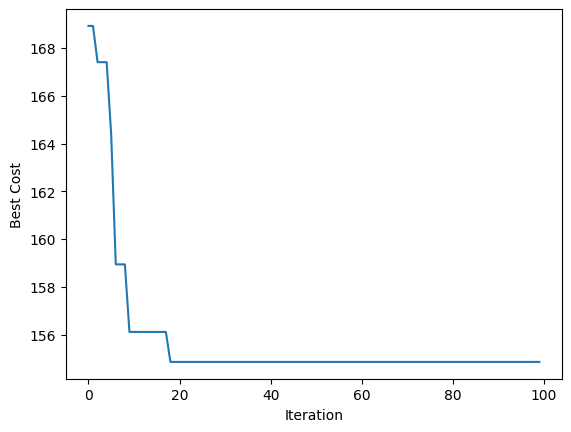

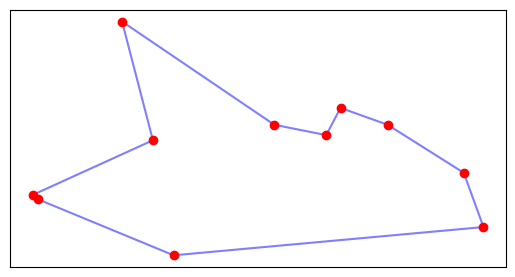

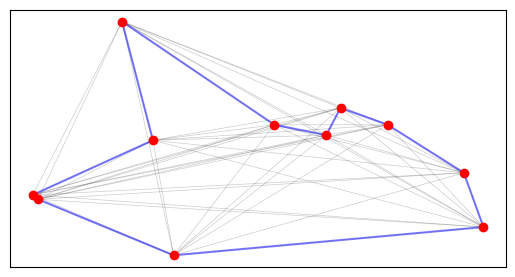

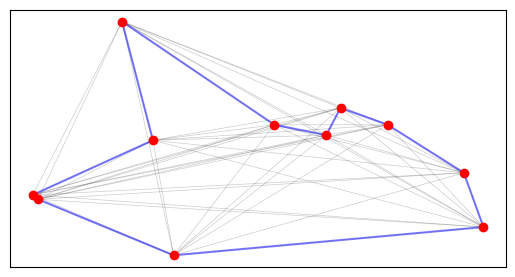

In [15]:
aco_sp11 = ACO(sp11, n=10, iterations=100)
aco_sp11.run(verbose=False)
aco_sp11.plot_convergence()
aco_sp11.plot_solution(edges=False)
aco_sp11.plot_animation(filename='aco_sp11', save=True)
aco_sp11.plot_solution_animation(filename='aco_sp11_tour', save=True)

/tmp/ipykernel_3881/2834329955.py:19: RuntimeWarning: divide by zero encountered in divide
  self.eta = 1 / model.adj # heuristic information


Best Tour: [10, 6, 3, 11, 7, 2, 4, 9, 0, 5, 1, 8, 10]
Best Cost: 1872.7805677890262
Time taken: 0.677007 seconds


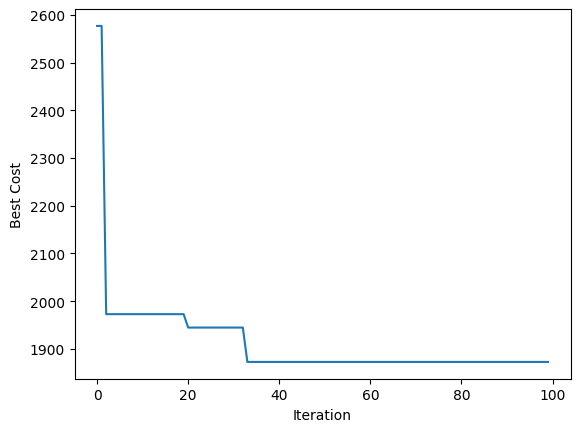

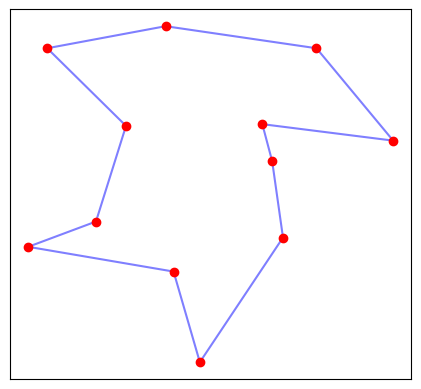

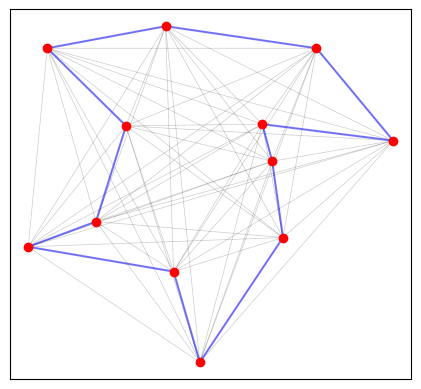

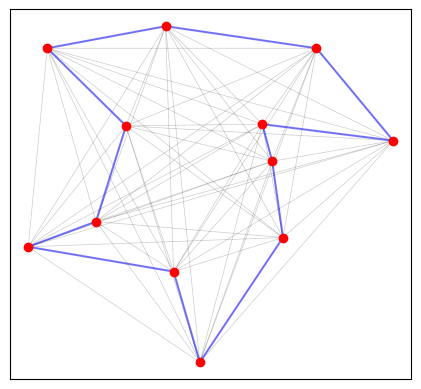

In [16]:
uk12_aco = ACO(uk12, n=10, iterations=100)
uk12_aco.run(verbose=False)
uk12_aco.plot_convergence()
uk12_aco.plot_solution(edges=False)
uk12_aco.plot_animation(filename='uk12_aco', save=True)
uk12_aco.plot_solution_animation(filename='uk12_aco_tour', save=True)

/tmp/ipykernel_3881/2834329955.py:19: RuntimeWarning: divide by zero encountered in divide
  self.eta = 1 / model.adj # heuristic information


Best Tour: [35, 30, 5, 40, 22, 2, 48, 39, 46, 41, 47, 16, 1, 55, 21, 3, 24, 37, 8, 26, 51, 36, 9, 13, 44, 29, 31, 23, 45, 42, 49, 34, 33, 18, 38, 17, 25, 50, 0, 20, 14, 28, 56, 27, 10, 12, 54, 6, 57, 11, 52, 4, 32, 43, 19, 15, 58, 7, 53, 35]
Best Cost: 1198.3397508639327
Time taken: 19.072685 seconds


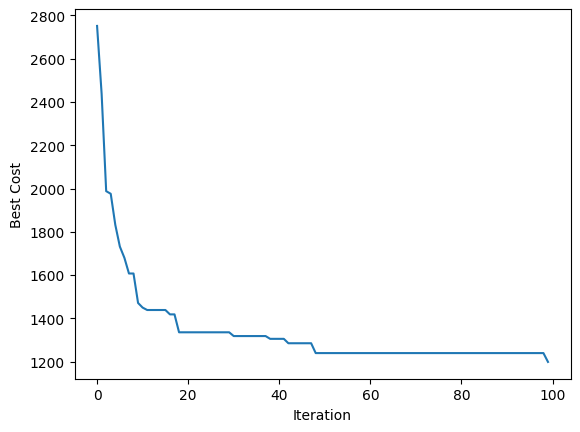

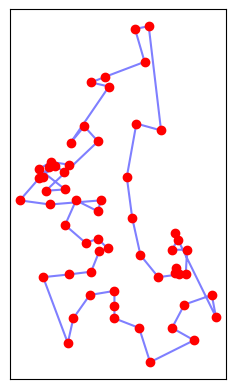

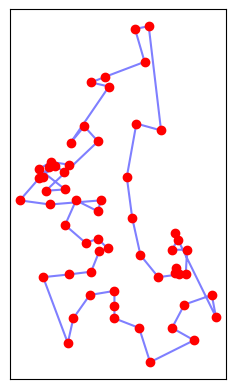

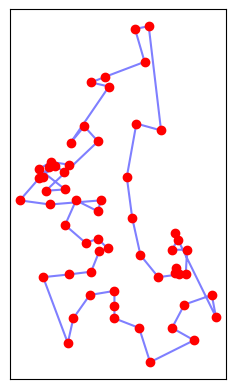

In [17]:

wg59_aco_small = ACO(wg59, n=100, iterations=100)
wg59_aco_small.run(verbose=False)
wg59_aco_small.plot_convergence()
wg59_aco_small.plot_solution(edges=False)
wg59_aco_small.plot_animation(filename='wg59_aco_small', edges=False, save=True)
wg59_aco_small.plot_solution_animation(filename='wg95_aco_small_tour', edges=False, save=True)

/tmp/ipykernel_28510/3697298632.py:19: RuntimeWarning: divide by zero encountered in divide
  self.eta = 1 / model.adj # heuristic information


Best Tour: [10, 27, 56, 28, 0, 50, 25, 17, 20, 14, 6, 54, 12, 52, 11, 57, 15, 58, 47, 35, 30, 16, 22, 40, 41, 5, 46, 2, 48, 39, 21, 55, 1, 3, 24, 37, 26, 51, 8, 9, 36, 13, 44, 7, 53, 19, 43, 4, 32, 29, 31, 42, 45, 23, 49, 34, 18, 38, 33, 10]
Best Cost: 1098.5292118713435
Time taken: 1578.902807 seconds


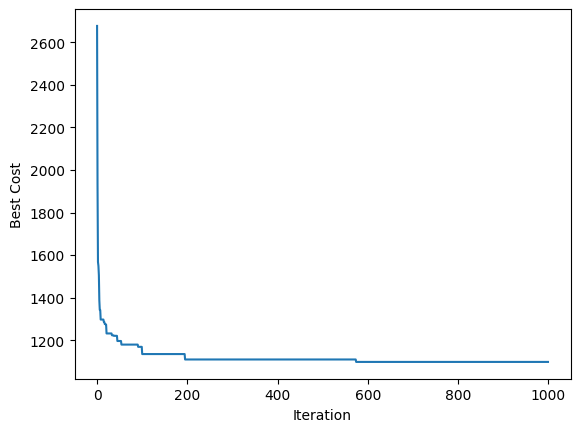

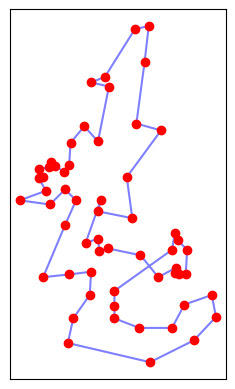

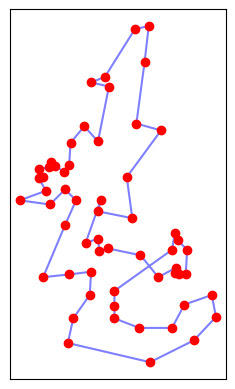

In [8]:
wg59_aco = ACO(wg59, n=1000, iterations=1000)
wg59_aco.run(verbose=False)
wg59_aco.plot_convergence()
wg59_aco.plot_solution(edges=False)
wg59_aco.plot_animation(filename='wg59_aco', edges=False, save=True)

### References

Project Code: YOEA103 "Project Title: Ant Colony Optimization for Traveling Salesman Problem"

Yarpiz (www.yarpiz.com)

S. Mostapha Kalami Heris